# Analysis


In [184]:
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns



#load csv into dataframe
loans_data = pd.read_csv('Data_Post_Transformation.csv')
loans_data.drop('Unnamed: 0', axis='columns', inplace=True)

log_convert_back = ['recoveries',
                    'total_rec_late_fee',
                    'delinq_2yrs',
                    'inq_last_6mths',
                    'annual_inc',
                    'out_prncp',
                    'out_prncp_inv',
                    'last_payment_amount',
                    'collections_12_mths_ex_med',
                    'collection_recovery_fee']

#restore log_converted columns back to pre-transformation values

for col in log_convert_back:
    loans_data[col] = loans_data[col].map(lambda x: np.exp(x) if x > 0 else 0)

pd.set_option('display.max_columns', None)

## Current state of the loans

Here we analyse what percentage of investor funds has been recouped as well as what is projected to be recouped in 6 months time.

In [80]:
# calculate basic loan summary information
percentage_recouped_inv = round(len(loans_data[loans_data['out_prncp_inv']==0])/len(loans_data)*100,2)
total_funded = loans_data['funded_amount'].sum()
funded_percent_inv = round((loans_data['out_prncp_inv'].sum() / loans_data['funded_amount_inv'].sum())*100,2)

print(f'The percentage of loans recovered against the investor funding is {percentage_recouped_inv}%')
print(f'The percentage of investor funding returned is {funded_percent_inv}%')
print(f'The total amount funded is {total_funded:,}')

#calculate loan value in 6 months for each loan
loans_data['remaining_in_6mths'] = ''
for index, row in loans_data.iterrows():
    value = row['out_prncp'] #set start value as current loan value
    mths = 6
    while mths > 0:
        value = (value * (1+(row['int_rate']/12/100))) - row['instalment'] #add interest for monthly period and deduct instalment
        mths -= 1 #deduct month from count
    
    loans_data.at[index, 'remaining_in_6mths'] = value #set remaining value as value of loan after 6 months

loans_data['remaining_in_6mths'] = np.where(loans_data['remaining_in_6mths']<=0,0,loans_data['remaining_in_6mths'])  #set negative values to zero on projection

funds_returned_6mths = round(((loans_data['remaining_in_6mths'].sum() + loans_data['out_prncp_inv'].sum()) / loans_data['funded_amount_inv'].sum())*100,2)

loans_data['status_6mths'] = np.where(loans_data['remaining_in_6mths']>0,"Open","Recovered")    

colors = ['green','blue']

pie_fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

pie_fig.add_trace(go.Pie(labels=['Returned','Pending'], values=[funded_percent_inv,100-funded_percent_inv], name="Current"),
              row=1, col=1)
pie_fig.add_trace(go.Pie(labels=['Returned','Pending'], values=[funds_returned_6mths,100-funds_returned_6mths], name="6 month projection",),
              row=1, col=2)

# Use `hole` to create a donut-like pie chart
pie_fig.update_traces(hole=.4, hoverinfo="label+percent", marker=dict(colors=colors))

pie_fig.update_layout(
    title_text="<b>Investor Funds Returned:</b> Current vs. 6 month projection",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='<b>Current</b>', x=0.18, y=0.5, font_size=18, showarrow=False),
                 dict(text='<b>Projection</b>', x=0.84, y=0.5, font_size=18, showarrow=False)])

pie_fig.show(config={'displayModeBar':False})

The percentage of loans recovered against the investor funding is 61.75%
The percentage of investor funding returned is 19.61%
The total amount funded is 398,914,525.0


## Calculating projected losses

What percentage of loans have been a loss to the company? Loans marked as Charged Off in the loan_status column represent a loss to the company.


Calculate the percentage of charged off loans historically and amount that was paid towards these loans before being charged off.

In [218]:
charged_off = ['Charged Off','Does not meet the credit policy. Status:Charged Off']

percent_charged_off = round(len(loans_data[loans_data['loan_status'].isin(charged_off)]) / len(loans_data),2)*100

charged_off_repaid = round(loans_data.query('loan_status in @charged_off')['total_payment'].sum(),2)

print(f'The percentage of "charged off" loans in the dataset is {percent_charged_off}%\n')

print(f'The total recouped from "charged off" loans is {charged_off_repaid:,}')

#calculate total value of each loan

loans_data['total_loan_value'] = ''
for index, row in loans_data.iterrows():
    loan = row['loan_amount']
    int_rate = row['int_rate']/12/100
    term = row['term']
    instalment = row['instalment']
    loan_value = row['loan_amount']
   
    while term > 0:
        loan_value += loan * (1+int_rate) - loan
        loan = loan * (1+int_rate)
        loan = loan - instalment
        term -= 1

    loans_data.at[index, 'total_loan_value'] = round(loan_value,2)

loans_data['total_lost'] = np.where(loans_data['loan_status'].isin(charged_off),loans_data['total_loan_value']-loans_data['total_payment'],0)

total_lost_charged_off = loans_data['total_lost'].sum()

percent_charged_off = total_lost_charged_off / loans_data.query('loan_status in @charged_off')['total_loan_value'].sum()*100

print(f'\nThe projected loss of "charged off loans is {round(total_lost_charged_off,2):,}: this is {round(percent_charged_off,2)}% of the expected revenue for these loans')


The percentage of "charged off" loans in the dataset is 9.0%

The total recouped from "charged off" loans is 17,117,604.89

The projected loss of "charged off loans is 32,416,485.94: this is 65.44% of the expected revenue for these loans


## Possible losses 

There are customers who are currently behind with their loan payments this subset of customers represent a risk to company revenue.

What percentage do users' in this bracket currently represent as a percentage of all loans? Calculate the total amount of customers in this bracket and how much loss the company would loss if these users status changed to Charged Off. What is the projected loss of these loans if the customer were to finish the loans term?

If customers converted to Charged Off, what percentage of total revenue do these customers and the customers who have already defaulted on their loan represent?

In [224]:
late_status = ['Late (31-120 days)', 'Late (16-30 days)','Default']

late_accounts = len(loans_data[loans_data['loan_status'].isin(late_status)])

print(f'{late_accounts} accounts are currently behind with their payments, this is {round(late_accounts/len(loans_data),2)*100}% of all accounts.')

potential_late_losses = loans_data.query('loan_status in @late_status')['total_loan_value'].sum() - loans_data.query('loan_status in @late_status')['total_payment'].sum()

total_loan_revenue = loans_data['total_loan_value'].sum()

late_and_charged_total = round(((potential_late_losses + total_lost_charged_off) / total_loan_revenue),2)

print(f'\nThe projected losses due to late accounts converting to "Charged off" status is {round(potential_late_losses,2):,}')

print(f'\nShould the late accounts become charged off, this would take the total revenue loss to {round(potential_late_losses + total_lost_charged_off,2):,} ({round(late_and_charged_total*100,2)}% of total revenue {round(total_loan_revenue,2):,})')

367 accounts are currently behind with their payments, this is 1.0% of all accounts.

The projected losses due to late accounts converting to "Charged off" status is 2,849,608.65

Should the late accounts become charged off, this would take the total revenue loss to 35,266,094.59 (7.0% of total revenue 503,296,195.93)


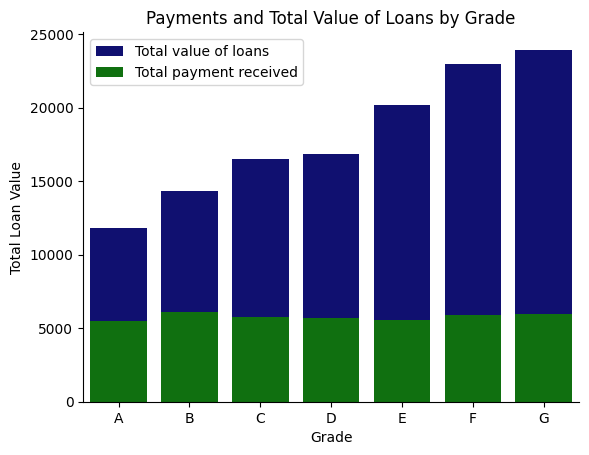

In [242]:
late_and_co = loans_data[(loans_data['loan_status'].isin(charged_off)) | (loans_data['loan_status'].isin(late_status))]

grade_order = ['A','B','C','D','E','F','G']

ax2 = plt.subplots()
ax2 = sns.barplot(x=late_and_co['grade'], y=late_and_co['total_loan_value'], color='navy', label='Total value of loans', errorbar=None, order=grade_order)
ax2 = sns.barplot(x=late_and_co['grade'], y=late_and_co['total_payment'], color='green', label='Total payment received', errorbar=None, order=grade_order)

ax2.set(xlabel="Grade", ylabel="Total Loan Value", title="Payments and Total Value of Loans by Grade")
sns.despine()
plt.legend()
plt.show()